# Machine Learning

## Libraries

In [1]:
import os
from typing import Any

import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from pygam import LinearGAM, s
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_squared_error,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

pd.set_option("display.max_columns", 30)
pd.set_option("display.width", 1440)
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

## Load processed dataframe

In [2]:
dataframe: pd.DataFrame = pd.read_csv("../data/processed/data.csv")
dataframe

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,False,True,False,1,False,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,True,Electronic check,29.85,29.85,No
1,Male,False,False,False,34,True,No,DSL,Yes,No,Yes,No,No,No,One year,False,Mailed check,56.95,1889.50,No
2,Male,False,False,False,2,True,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,True,Mailed check,53.85,108.15,Yes
3,Male,False,False,False,45,False,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,False,Bank transfer (automatic),42.30,1840.75,No
4,Female,False,False,False,2,True,No,Fiber optic,No,No,No,No,No,No,Month-to-month,True,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,False,True,True,24,True,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,True,Mailed check,84.80,1990.50,No
7039,Female,False,True,True,72,True,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,True,Credit card (automatic),103.20,7362.90,No
7040,Female,False,True,True,11,False,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,True,Electronic check,29.60,346.45,No
7041,Male,True,True,False,4,True,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,True,Mailed check,74.40,306.60,Yes


In [3]:
df_dummies: pd.DataFrame = pd.read_csv("../data/processed/df_dummies.csv")
df_dummies

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,...,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,1,0,1,0,0,1,1,0,1,0,0,...,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,34,56.95,1889.50,0,0,1,1,0,1,0,1,0,0,1,1,...,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,1,1,0,1,0,1,0,0,1,1,...,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,0,0,1,1,0,1,0,1,0,1,0,0,...,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,1,1,0,1,0,1,0,1,0,0,1,1,...,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,84.80,1990.50,0,0,1,1,0,0,1,0,1,0,1,0,...,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1
7039,72,103.20,7362.90,0,1,0,1,0,0,1,0,1,0,1,0,...,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0
7040,11,29.60,346.45,0,1,0,1,0,0,1,0,1,1,0,0,...,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
7041,4,74.40,306.60,1,0,1,0,1,0,1,1,0,0,1,0,...,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1


## Preprocessing

In [4]:
y: np.ndarray = df_dummies["Churn"].values
x: pd.DataFrame = df_dummies.drop(columns=["Churn"])

features: np.ndarray = x.columns.values

## Normalizing data

In [5]:
standard_scaler: StandardScaler = StandardScaler()
x_scaled = standard_scaler.fit_transform(x)

# Splitting data

In [6]:
x_unbalanced, x_test, y_unbalanced, y_test = train_test_split(
    x_scaled, y, test_size=0.2, random_state=42
)

## Balancing data

In [7]:
smote: SMOTE = SMOTE(sampling_strategy="auto", random_state=42)
x_train, y_train = smote.fit_resample(x_unbalanced, y_unbalanced)

## Pipeline

### Training

In [8]:
def train_model(
    independent_training_data: np.ndarray,
    dependant_training_data: np.ndarray,
    pipeline: Pipeline,
    param_grid: dict[str, Any],
) -> tuple[Pipeline, GridSearchCV]:
    """
    Train a model using GridSearchCV
    :param independent_training_data: the independent variables of the training
    data
    :type independent_training_data: np.ndarray
    :param dependant_training_data: the dependant variable for training
    :type dependant_training_data: np.ndarray
    :param pipeline: The pipeline to use
    :type pipeline: Pipeline
    :param param_grid: the parameters to tune the model
    :type param_grid: dict[str, Any]
    :return: The best model and its parameters
    :rtype: tuple[Pipeline, GridSearchCV]
    """
    grid_search: GridSearchCV = GridSearchCV(
        pipeline, param_grid, scoring="accuracy", cv=5
    )
    grid_search.fit(independent_training_data, dependant_training_data)
    return grid_search.best_estimator_, grid_search

### Evaluation

In [9]:
def evaluate_model(
    model: Pipeline,
    independent_testing_data: np.ndarray,
    dependent_testing_data: np.ndarray,
) -> None:
    """
    Evaluate the model on the test set
    :param model: The best model to evaluate
    :type model: Pipeline
    :param independent_testing_data: the test data for independent variables
    :type independent_testing_data: np.ndarray
    :param dependent_testing_data: the test data for dependant variable
    :type dependent_testing_data: np.ndarray
    :return: None
    :rtype: NoneType
    """
    y_pred: np.ndarray = model.predict(independent_testing_data)
    if hasattr(model, "predict_proba"):
        y_proba: np.ndarray = model.predict_proba(independent_testing_data)
        roc_auc: float
        if y_proba.shape[1] > 2:
            y_test_binarized = label_binarize(
                dependent_testing_data,
                classes=np.unique(dependent_testing_data),
            )
            roc_auc = roc_auc_score(
                y_test_binarized, y_proba, multi_class="ovr"
            )
        else:
            roc_auc = roc_auc_score(dependent_testing_data, y_proba[:, 1])
        print(f"ROC-AUC: {roc_auc:.4f}")

    accuracy: float = accuracy_score(dependent_testing_data, y_pred)
    precision: float = precision_score(
        dependent_testing_data, y_pred, average="weighted"
    )
    recall: float = recall_score(
        dependent_testing_data, y_pred, average="weighted"
    )
    f1: float = f1_score(dependent_testing_data, y_pred, average="weighted")

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(dependent_testing_data, y_pred))

## Machine Learning models

### Support Vector Machine (SVM)

In [10]:
pipeline_svc: Pipeline = Pipeline(
    [("scaler", StandardScaler()), ("svc", SVC(random_state=42))]
)
param_grid_svc: dict[str, list[Any]] = {
    "svc__C": [0.1, 1, 10, 100],
    "svc__kernel": ["linear", "rbf"],
    "svc__gamma": ["scale", "auto"],
}
best_model_svc, grid_search_svc = train_model(
    x_train, y_train, pipeline_svc, param_grid_svc
)
evaluate_model(best_model_svc, x_test, y_test)

Accuracy: 0.7651
Precision: 0.7842
Recall: 0.7651
F1-score: 0.7719
Confusion Matrix:
[[829 207]
 [124 249]]


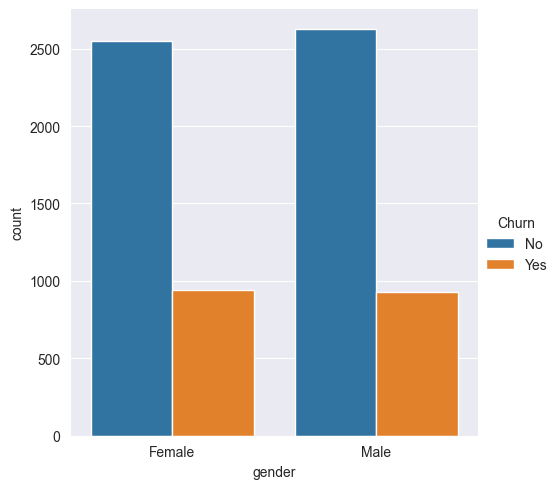

In [11]:
ax1 = sns.catplot(
    data=dataframe,
    x="gender",
    hue="Churn",
    kind="count",
    estimator=lambda e: sum(e == 0) * 100.0 / len(e),
)

### Gradient Boosting Machines (GBM)

In [12]:
pipeline_gbm: Pipeline = Pipeline(
    [("model", GradientBoostingClassifier(random_state=42))]
)
param_grid_gbm: dict[str, list[Any]] = {
    "model__n_estimators": [100, 200, 300],
    "model__learning_rate": [0.01, 0.1, 0.2],
    "model__max_depth": [3, 4, 5],
    "model__subsample": [
        0.8,
        0.9,
        1.0,
    ],
}
best_model_gbm, grid_search_gbm = train_model(
    x_train, y_train, pipeline_gbm, param_grid_gbm
)
evaluate_model(best_model_gbm, x_test, y_test)

ROC-AUC: 0.8435
Accuracy: 0.7963
Precision: 0.7951
Recall: 0.7963
F1-score: 0.7957
Confusion Matrix:
[[896 140]
 [147 226]]


### Adaptive Boosting (AdaBoost)

In [13]:
pipeline_adaboost: Pipeline = Pipeline(
    [
        (
            "model",
            AdaBoostClassifier(
                DecisionTreeClassifier(max_depth=1, random_state=42),
                algorithm="SAMME",
                random_state=42,
            ),
        )
    ]
)
param_grid_adaboost: dict[str, list[Any]] = {
    "model__n_estimators": [50, 100, 200],
    "model__learning_rate": [0.01, 0.1, 1],
    "model__estimator__max_depth": [1, 2],
}
best_model_adaboost, grid_search_adaboost = train_model(
    x_train, y_train, pipeline_adaboost, param_grid_adaboost
)
evaluate_model(best_model_adaboost, x_test, y_test)

ROC-AUC: 0.8522
Accuracy: 0.7892
Precision: 0.8113
Recall: 0.7892
F1-score: 0.7963
Confusion Matrix:
[[838 198]
 [ 99 274]]


### Generalized Additive Models (GAM)

In [14]:
lambdas: np.ndarray = np.logspace(-3, 3, 7)
best_score: float = np.inf
best_lambda = None
best_model = None

In [15]:
for lam in lambdas:
    gam = LinearGAM(s(0, lam=lam) + s(1, lam=lam)).fit(x_train, y_train)
    predictions: np.ndarray = gam.predict(x_test)
    score: float = mean_squared_error(y_test, predictions)
    if score < best_score:
        best_score = score
        best_lambda = lam
        best_model = gam

In [16]:
print(f"Best Lambda: {best_lambda}")
print(f"Best MSE: {best_score}")
print(type(best_lambda), type(best_model), type(best_score))
print(best_model.summary())

Best Lambda: 10.0
Best MSE: 0.17436863242753023
<class 'numpy.float64'> <class 'pygam.pygam.LinearGAM'> <class 'numpy.float64'>
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     24.1164
Link Function:                     IdentityLink Log Likelihood:                                -16853.3034
Number of Samples:                         8276 AIC:                                            33756.8395
                                                AICc:                                           33756.9985
                                                GCV:                                                0.1748
                                                Scale:                                              0.1739
                

C:\Users\juanp\AppData\Local\Temp\ipykernel_15068\2151649304.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(best_model.summary())


### Random Forest

In [17]:
pipeline_rf: Pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("rf", RandomForestClassifier(n_jobs=-1, random_state=42)),
    ]
)

param_grid_rf: dict[str, list[Any]] = {
    "rf__n_estimators": [100, 200, 300],
    "rf__max_depth": [None, 10, 20, 30],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["sqrt", "log2", None],
}

best_model_rf, grid_search_rf = train_model(
    x_train, y_train, pipeline_rf, param_grid_rf
)
evaluate_model(best_model_rf, x_test, y_test)

ROC-AUC: 0.8377
Accuracy: 0.7921
Precision: 0.7937
Recall: 0.7921
F1-score: 0.7928
Confusion Matrix:
[[885 151]
 [142 231]]
